The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Gradiente descendente
:label:`sec_gd`

Nesta seção, apresentaremos os conceitos básicos da descida gradiente. Isso é breve por necessidade. Veja, por exemplo, :cite:`Boyd.Vandenberghe.2004` para uma introdução detalhada à otimização convexa. Embora o último raramente seja usado diretamente no aprendizado profundo, uma compreensão da descida gradiente é a chave para entender os algoritmos de descida gradiente estocásticos. Por exemplo, o problema de otimização pode divergir devido a uma taxa de aprendizado excessivamente grande. Este fenômeno já pode ser visto na descida do gradiente. Da mesma forma, o pré-condicionamento é uma técnica comum na descida de gradiente e é transportado para algoritmos mais avançados. Comecemos com um caso especial simples.

## Gradiente descendente em uma dimensão

A descida gradiente em uma dimensão é um excelente exemplo para explicar por que o algoritmo de descida gradiente pode reduzir o valor da função objetivo. Considere alguma função de valor real continuamente diferenciável $f: \mathbb{R} \rightarrow \mathbb{R}$. Usando uma expansão de Taylor (:numref:`sec_single_variable_calculus`), obtemos que

$$f(x + \epsilon) = f(x) + \epsilon f'(x) + \mathcal{O}(\epsilon^2).$$
:eqlabel:`gd-taylor`

Ou seja, na primeira aproximação $f(x+\epsilon)$ é dado pelo valor da função $f(x)$ e a primeira derivada $f'(x)$ em $x$. Não é irracional supor que, para pequenos $\epsilon$ movendo-se na direção do gradiente negativo, $f$ diminuirá. Para manter as coisas simples, escolhemos um tamanho de passo fixo $\eta > 0$ e escolhemos $\epsilon = -\eta f'(x)$. Conectando isso à expansão Taylor acima, obtemos

$$f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + \mathcal{O}(\eta^2 f'^2(x)).$$

Se a derivada $f'(x) \neq 0$ não desaparecer, fazemos progresso, pois $\eta f'^2(x)>0$. Além disso, podemos sempre escolher $\eta$ pequeno o suficiente para que os termos de ordem superior se tornem irrelevantes. Daí chegamos a

$$f(x - \eta f'(x)) \lessapprox f(x).$$

Isso significa que, se usarmos

$$x \leftarrow x - \eta f'(x)$$

para iterar $x$, o valor da função $f(x)$ pode diminuir. Portanto, na descida do gradiente, primeiro escolhemos um valor inicial $x$ e uma constante $\eta > 0$ e, em seguida, os usamos para iterar continuamente $x$ até que a condição de parada seja alcançada, por exemplo, quando a magnitude do gradiente $|f'(x)|$ é pequeno o suficiente ou o número de iterações atingiu um determinado valor.

Para simplificar, escolhemos a função objetivo $f(x)=x^2$ para ilustrar como implementar a descida gradiente. Embora saibamos que $x=0$ é a solução para minimizar $f(x)$, ainda usamos esta função simples para observar como $x$ muda. Como sempre, começamos importando todos os módulos necessários.


In [1]:
%matplotlib inline
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
f = lambda x: x**2  # Objective function
gradf = lambda x: 2 * x  # Its derivative

Em seguida, usamos $x=10$ como o valor inicial e assumimos $\eta=0,2$. Usando a descida gradiente para iterar $x$ por 10 vezes, podemos ver que, eventualmente, o valor de $x$ se aproxima da solução ótima.


In [3]:
def gd(eta):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * gradf(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

res = gd(0.2)

epoch 10, x: 0.06046617599999997


O progresso da otimização em $x$ pode ser traçado da seguinte maneira.


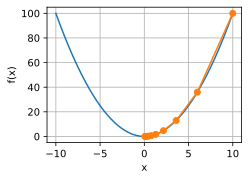

In [4]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, res], [[f(x) for x in f_line], [f(x) for x in res]],
             'x', 'f(x)', fmts=['-', '-o'])

show_trace(res)

### Taxa de Aprendizagem
:label:`section_gd-learningrate`

A taxa de aprendizagem $\eta$ pode ser definida pelo designer do algoritmo. Se usarmos uma taxa de aprendizado muito pequena, a atualização de $x$ será muito lenta, exigindo mais iterações para obter uma solução melhor. Para mostrar o que acontece nesse caso, considere o progresso no mesmo problema de otimização para $\eta = 0,05$. Como podemos ver, mesmo após 10 passos ainda estamos muito longe da solução ótima.


epoch 10, x: 3.4867844009999995


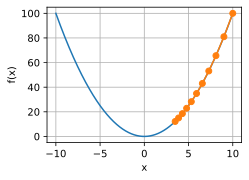

In [5]:
show_trace(gd(0.05))

Por outro lado, se usarmos uma taxa de aprendizado excessivamente alta, $\left|\eta f'(x)\right|$ pode ser muito grande para a fórmula de expansão de Taylor de primeira ordem. Ou seja, o termo $\mathcal{O}(\eta^2 f'^2(x))$ in :eqref:`gd-taylor` pode se tornar significativo. Nesse caso, não podemos garantir que a iteração de $x$ será capaz de diminuir o valor de $f(x)$. Por exemplo, quando definimos a taxa de aprendizagem para $\eta=1.1$, $x$ ultrapassa a solução ótima $x=0$ e diverge gradualmente.


epoch 10, x: 61.917364224000096


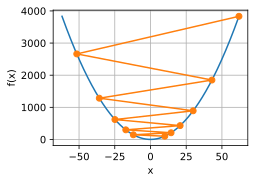

In [6]:
show_trace(gd(1.1))

### Minimo Local

Para ilustrar o que acontece com funções não convexas, considere o caso de $f(x) = x \cdot \cos c x$. Esta função possui infinitos mínimos locais. Dependendo de nossa escolha da taxa de aprendizado e de quão bem condicionado o problema está, podemos chegar a uma de muitas soluções. O exemplo abaixo ilustra como uma alta taxa de aprendizado (irrealista) levará a um mínimo local insatisfatório.


epoch 10, x: tensor(-1.5282)


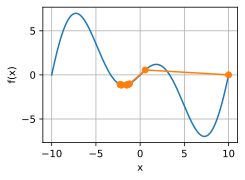

In [7]:
c = torch.tensor(0.15 * np.pi)
f = lambda x: x * torch.cos(c * x)
gradf = lambda x: torch.cos(c * x) - c * x * torch.sin(c * x)
show_trace(gd(2))

## Gradiente descendente multivariado

Agora que temos uma melhor intuição do caso univariado, consideremos a situação em que $\mathbf{x} \in \mathbb{R}^d$. Ou seja, a função objetivo $f: \mathbb{R}^d \to \mathbb{R}$ mapeia vetores em escalares. Correspondentemente, seu gradiente também é multivariado. É um vetor que consiste em $d$ derivadas parciais:

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$$

Cada elemento derivado parcial $\partial f(\mathbf{x})/\partial x_i$ no gradiente indica a taxa de variação de $f$ em $\mathbf{x}$ em relação à entrada $x_i$. Como antes, no caso univariado, podemos usar a aproximação de Taylor correspondente para funções multivariadas para ter uma ideia do que devemos fazer. Em particular, temos que

$$f(\mathbf{x} + \mathbf{\epsilon}) = f(\mathbf{x}) + \mathbf{\epsilon}^\top \nabla f(\mathbf{x}) + \mathcal{O}(\|\mathbf{\epsilon}\|^2).$$
:eqlabel:`gd-multi-taylor`

Em outras palavras, até os termos de segunda ordem em $\mathbf{\epsilon}$, a direção da descida mais acentuada é dada pelo gradiente negativo $-\nabla f(\mathbf{x})$. A escolha de uma taxa de aprendizagem adequada $\eta > 0$ produz o algoritmo de descida gradiente prototípico:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$$

Para ver como o algoritmo se comporta na prática, vamos construir uma função objetivo $f(\mathbf{x})=x_1^2+2x_2^2$ com um vetor bidimensional $\mathbf{x} = [x_1, x_2]^\top$ como entrada e um escalar como saída. O gradiente é dado por $ \ nabla f (\ mathbf {x}) = [2x_1, 4x_2] ^ \ top $. Observaremos a trajetória de $\mathbf{x}$ por gradiente descendente a partir da posição inicial $[-5, -2]$. Precisamos de mais duas funções auxiliares. O primeiro usa uma função de atualização e aplica $ 20 $ vezes ao valor inicial. O segundo auxiliar visualiza a trajetória de $\mathbf{x}$.


In [8]:
def train_2d(trainer, steps=20):  #@save
    """Optimize a 2-dim objective function with a customized trainer."""
    # s1 and s2 are internal state variables and will
    # be used later in the chapter
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    return results

def show_trace_2d(f, results):  #@save
    """Show the trace of 2D variables during optimization."""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

A seguir, observamos a trajetória da variável de otimização $\mathbf{x}$ para a taxa de aprendizagem $\eta = 0.1$. Podemos ver que após 20 passos o valor de $\mathbf{x}$ se aproxima de seu mínimo em $[0, 0]$. O progresso é bastante bem comportado, embora bastante lento.


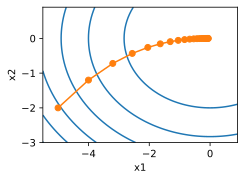

In [9]:
f = lambda x1, x2: x1 ** 2 + 2 * x2 ** 2  # Objective
gradf = lambda x1, x2: (2 * x1, 4 * x2)  # Gradient

def gd(x1, x2, s1, s2):
    (g1, g2) = gradf(x1, x2)  # Compute gradient
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)  # Update variables

eta = 0.1
show_trace_2d(f, train_2d(gd))

## Métodos Adaptativos

Como pudemos ver em :numref:`section_gd-learningrate`, obter a taxa de aprendizado $\eta$ "na medida certa" é complicado. Se o pegarmos muito pequeno, não faremos progresso. Se o escolhermos muito grande, a solução oscila e, no pior dos casos, pode até divergir. E se pudéssemos determinar $\eta$ automaticamente ou nos livrarmos da necessidade de selecionar um tamanho de passo? Métodos de segunda ordem que olham não apenas para o valor e gradiente da objetiva, mas também para sua *curvatura* podem ajudar neste caso. Embora esses métodos não possam ser aplicados ao aprendizado profundo diretamente devido ao custo computacional, eles fornecem intuição útil sobre como projetar algoritmos de otimização avançados que imitam muitas das propriedades desejáveis dos algoritmos descritos abaixo.


### Método de Newton

Revendo a expansão de Taylor de $f$, não há necessidade de parar após o primeiro mandato. Na verdade, podemos escrever como

$$f(\mathbf{x} + \mathbf{\epsilon}) = f(\mathbf{x}) + \mathbf{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \mathbf{\epsilon}^\top \nabla \nabla^\top f(\mathbf{x}) \mathbf{\epsilon} + \mathcal{O}(\|\mathbf{\epsilon}\|^3).$$
:eqlabel:`gd-hot-taylor`

Para evitar notações complicadas, definimos $H_f := \nabla \nabla^\top f(\mathbf{x})$ como o *Hessiano* de $f$. Esta é uma matriz $d \times d$. Para $d$ pequenos e problemas simples, $H_f$ é fácil de calcular. Para redes profundas, por outro lado, $H_f$ pode ser proibitivamente grande, devido ao custo de armazenamento de $\mathcal{O}(d^2)$ entradas. Além disso, pode ser muito caro computar por retropropagação, pois precisaríamos aplicar a retropropagação ao gráfico de chamada de retropropagação. Por enquanto, vamos ignorar essas considerações e ver que algoritmo obteríamos.

Afinal, o mínimo de $f$ satisfaz $\nabla f(\mathbf{x}) = 0$. Pegando derivados de :eqref:`gd-hot-taylor` em relação a $\mathbf{\epsilon}$ e ignorando termos de ordem superior, chegamos a

$$\nabla f(\mathbf{x}) + H_f \mathbf{\epsilon} = 0 \text{ and hence }
\mathbf{\epsilon} = -H_f^{-1} \nabla f(\mathbf{x}).$$

Ou seja, precisamos inverter o Hessian $H_f$ como parte do problema de otimização.

Para $f(x) = \frac{1}{2} x^2$ temos $\nabla f(x) = x$ e $H_f = 1$. Portanto, para qualquer $x$ obtemos $\epsilon = -x$. Em outras palavras, um único passo é suficiente para convergir perfeitamente sem a necessidade de nenhum ajuste! Infelizmente, tivemos um pouco de sorte aqui, já que a expansão de Taylor foi exata. Vamos ver o que acontece em outros problemas.


epoch 10, x: tensor(0.)


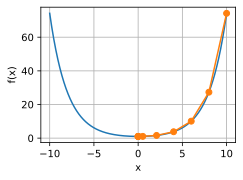

In [10]:
c = torch.tensor(0.5)
f = lambda x: torch.cosh(c * x)  # Objective
gradf = lambda x: c * torch.sinh(c * x)  # Derivative
hessf = lambda x: c**2 * torch.cosh(c * x)  # Hessian

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * gradf(x) / hessf(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton())

Agora vamos ver o que acontece quando temos uma função *não convexa*, como $f(x) = x \cos(c x)$. Afinal, observe que no método de Newton acabamos nos dividindo pelo Hessiano. Isso significa que se a segunda derivada for *negativa*, caminharíamos na direção de *aumentar* $f$. Essa é uma falha fatal do algoritmo. Vamos ver o que acontece na prática.


epoch 10, x: tensor(26.8341)


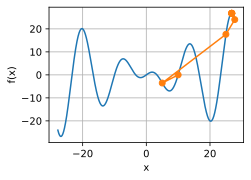

In [11]:
c = torch.tensor(0.15 * np.pi)
f = lambda x: x * torch.cos(c * x)
gradf = lambda x: torch.cos(c * x) - c * x * torch.sin(c * x)
hessf = lambda x: - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton())

Isso deu espetacularmente errado. Como podemos arranjá-lo? Uma maneira seria "consertar" o Hessian tomando seu valor absoluto. Outra estratégia é trazer de volta a taxa de aprendizado. Isso parece anular o propósito, mas não totalmente. Ter informações de segunda ordem permite-nos ser cautelosos sempre que a curvatura for grande e dar passos mais longos sempre que a objetiva for plana. Vamos ver como isso funciona com uma taxa de aprendizado um pouco menor, digamos $\eta = 0.5$. Como podemos ver, temos um algoritmo bastante eficiente.


epoch 10, x: tensor(7.2699)


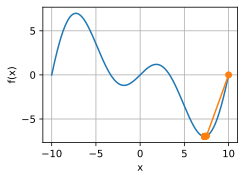

In [12]:
show_trace(newton(0.5))

### Análise de Convergência

Analisamos apenas a taxa de convergência para $f$ convexa e três vezes diferenciável, onde em seu mínimo $x^*$ a segunda derivada é diferente de zero, ou seja, onde $f''(x^*) > 0$. A prova multivariada é uma extensão direta do argumento abaixo e omitida por não nos ajudar muito em termos de intuição.

Denote por $x_k$ o valor de $x$ na $k$-ésima iteração e seja $e_k:= x_k - x^*$ a distância da otimização. Pela expansão da série de Taylor, temos que a condição $f'(x^*) = 0$ pode ser escrita como

$$0 = f'(x_k - e_k) = f'(x_k) - e_k f''(x_k) + \frac{1}{2} e_k^2 f'''(\xi_k).$$

Isso vale para alguns $\xi_k \in [x_k - e_k, x_k]$. Lembre-se de que temos a atualização $x_{k+1} = x_k - f'(x_k) / f''(x_k)$. Dividindo a expansão acima por $f''(x_k)$, obtemos

$$e_k - f'(x_k) / f''(x_k) = \frac{1}{2} e_k^2 f'''(\xi_k) / f''(x_k).$$

Conectar as equações de atualização leva ao seguinte limite $e_{k+1} \leq e_k^2 f'''(\xi_k) / f'(x_k)$. Consequentemente, sempre que estamos em uma região de $f'''(\xi_k) / f''(x_k) \leq c$ limitada, temos um erro quadraticamente decrescente $e_{k+1} \leq c e_k^2$.

À parte, os pesquisadores de otimização chamam isso de convergência *linear*, enquanto uma condição como $e_{k+1} \leq \alpha e_k$ seria chamada de taxa de convergência *constante*.
Observe que esta análise vem com uma série de advertências: Não temos muita garantia de quando alcançaremos a região de convergência rápida. Em vez disso, sabemos apenas que, uma vez que o alcance, a convergência será muito rápida. Em segundo lugar, isso requer que $f$ seja bem comportado com os derivados de ordem superior. Tudo se resume a garantir que $f$ não tenha nenhuma propriedade "surpreendente" em termos de como ele pode alterar seus valores.

### Precondicionamento

Sem surpresa, computar e armazenar o Hessian completo é muito caro. Portanto, é desejável encontrar alternativas. Uma maneira de melhorar as coisas é evitar calcular o Hessian em sua totalidade, mas apenas calcular as entradas * diagonais *. Embora isso não seja tão bom quanto o método de Newton completo, ainda é muito melhor do que não usá-lo. Além disso, as estimativas para os principais elementos diagonais são o que impulsiona algumas das inovações em algoritmos de otimização de descida de gradiente estocástico. Isso leva à atualização de algoritmos do formulário

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \mathrm{diag}(H_f)^{-1} \nabla f(\mathbf{x}).$$

Para ver por que isso pode ser uma boa ideia, considere uma situação em que uma variável denota a altura em milímetros e a outra denota a altura em quilômetros. Assumindo que para ambas a escala natural está em metros, temos um péssimo desencontro nas parametrizações. Usar o pré-condicionamento remove isso. O pré-condicionamento eficaz com gradiente descendente equivale a selecionar uma taxa de aprendizagem diferente para cada coordenada.

### Gradiente descendente com pesquisa de linha

Um dos principais problemas na descida gradiente era que poderíamos ultrapassar a meta ou fazer um progresso insuficiente. Uma solução simples para o problema é usar a pesquisa de linha em conjunto com a descida gradiente. Ou seja, usamos a direção dada por $\nabla f(\mathbf{x})$ e, em seguida, realizamos a pesquisa binária para saber qual o comprimento do passo $\eta$ minimiza $f(\mathbf{x} - \eta \nabla f(\mathbf{x}))$.

Este algoritmo converge rapidamente (para uma análise e prova veja, por exemplo, :cite:`Boyd.Vandenberghe.2004`). No entanto, para fins de aprendizado profundo, isso não é tão viável, uma vez que cada etapa da pesquisa de linha exigiria que avaliássemos a função objetivo em todo o conjunto de dados. Isso é muito caro de se realizar.

## Sumário

* As taxas de aprendizagem são importantes. Muito grande e divergimos, muito pequeno e não avançamos.
* A descida do gradiente pode ficar presa em mínimos locais.
* Em dimensões altas, ajustar a taxa de aprendizagem é complicado.
* O pré-condicionamento pode ajudar no ajuste da escala.
* O método de Newton é muito mais rápido *uma vez* que começou a funcionar corretamente em problemas convexos.
* Cuidado ao usar o método de Newton sem quaisquer ajustes para problemas não convexos.

## Exercícios

1. Experimente diferentes taxas de aprendizagem e funções objetivas para a descida do gradiente.
2. Implemente a pesquisa de linha para minimizar uma função convexa no intervalo $[a, b]$.
     * Você precisa de derivadas para pesquisa binária, ou seja, para decidir se deve escolher $[a, (a+b)/2]$ ou $[(a+b)/2, b]$.
     * Quão rápida é a taxa de convergência do algoritmo?
     * Implemente o algoritmo e aplique-o para minimizar $\log (\exp(x) + \exp(-2*x -3))$.
3. Projete uma função objetivo definida em $\mathbb{R}^2$ onde a descida do gradiente é excessivamente lenta. Dica: dimensione coordenadas diferentes de forma diferente.
4. Implemente a versão leve do método de Newton usando o pré-condicionamento:
     * Use diagonal Hessian como pré-condicionador.
     * Use os valores absolutos disso em vez dos valores reais (possivelmente com sinal).
     * Aplique isso ao problema acima.
5. Aplique o algoritmo acima a uma série de funções objetivo (convexas ou não). O que acontece se você girar as coordenadas em $45$ graus?

[Discussão](https://discuss.d2l.ai/t/351)

<!--stackedit_data:
eyJoaXN0b3J5IjpbMTYxMzc5OTM5MywtMTk5MzQ3NDc1NiwtMT
MxMTk3Nzg4MywtOTA3NDM2MzIxXX0=
-->
